# Capstone - Urban sound classification with UrbanSound8K dataset

## Background

Living in a dense urban environment such as Singapore means that residents are subjected to noise disturbances from various sources. For action to be taken on noise complaints, the offending noise source needs to be identified, which can be hard to isolate based on human senses alone in a dense environment. Being able to quantitatively identify the sources of noises will help speed up efforts to address noise complaints.  

## Problem Statement

* High-rise building residents often need to make noise complaints to the authorities (e.g. HDB and NEA). The only supporting evidence available tend to be video or sound recordings taken from the resident’s house, which can be unclear and hard to match to sources using human senses alone. Qualitative matching is also difficult to be presented as evidence to take action against the offending source. 
* Traditional approaches to mapping sound locations make use of arrays of microphones in the vicinity of the sound source, which is something typical residents do not have access to. 
* This project proposes training an AI model that can identify the type of urban noise based on an audio recording. This could help provide preliminary candidates for investigating sources of noise.

## Methodology

* Dataset

This study be using the UrbanSound8K (https://urbansounddataset.weebly.com/urbansound8k.html) dataset, which consists of 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The clips are taken from field recordings uploaded to www.freesound.org. 

* Approach

1. Extract unique features from each sound clip using the Mel-frequency cepstral coefficients(MFCC) technique. We will use the librosa library to carry this out. 
2. Train several models to identify the sound class based on the MFCC features. 
3. Choose the best model based on accuracy. 

## Data dictionary

The metadata of each sound recording will be imported via a csv file. The definitions of each column can be found below. For the training of our models, we will be using the 'slice_file_name' and 'classID' columns.

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold (folder) number (1-10) to which this file has been allocated.

* classID:
A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.

## Import Python packages and libraries

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
import os
import librosa
from librosa import display
from tqdm import tqdm #to track progress
import IPython.display as ipd
from scipy.io import wavfile as wav
from librosa.core import resample, to_mono
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_curve, roc_auc_score 
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv1D, Dense, Dropout, Activation, Flatten, MaxPooling2D, MaxPooling1D, Resizing, GlobalMaxPooling1D, TimeDistributed, LayerNormalization, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, History
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from multiprocessing.pool import ThreadPool

In [5]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Import annotations and file paths

In [143]:
download_path = 'UrbanSound8K/'

# Read metadata file
metadata_file = download_path+'metadata/UrbanSound8K.csv'
df_full = pd.read_csv(metadata_file)
df_full.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [145]:
len(df_full)

8732

In [13]:
#checking for nulls in metadata #none
df_full.isnull().mean()

slice_file_name    0.0
fsID               0.0
start              0.0
end                0.0
salience           0.0
fold               0.0
classID            0.0
class              0.0
relative_path      0.0
dtype: float64

In [23]:
df_full.duplicated().sum() #no duplicated rows

0

In [24]:
df_full.duplicated(subset = ['slice_file_name', 'class']).sum() 
#each sound file has its own label

0

In [144]:
# Construct file path by concatenating fold and file name
#df['relative_path'] = '/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)
df_full['relative_path'] = download_path + 'audio'+'/fold' + df_full['fold'].astype(str) + '/' + df_full['slice_file_name'].astype(str)

# Take relevant columns into a new dataframe
df = df_full[['relative_path', 'classID']]
df.head()

,relative_path,classID
0,UrbanSound8K/audio/fold5/100032-3-0-0.wav,3
1,UrbanSound8K/audio/fold5/100263-2-0-117.wav,2
2,UrbanSound8K/audio/fold5/100263-2-0-121.wav,2
3,UrbanSound8K/audio/fold5/100263-2-0-126.wav,2
4,UrbanSound8K/audio/fold5/100263-2-0-137.wav,2


In [7]:
len(df)

8732

## Create dictionary of sound taxonomy

In [8]:
taxonomy = {
0 : 'air_conditioner',
1 : 'car_horn',
2 : 'children_playing',
3 : 'dog_bark',
4 : 'drilling',
5 : 'engine_idling',
6 : 'gun_shot',
7 : 'jackhammer',
8 : 'siren',
9 : 'street_music',
}

taxonomy

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [141]:
#classes = list(taxonomy.values())
classes = list(taxonomy.keys())
print('classes:', classes)
names = list(taxonomy.values())
print('names:',names)

classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
names: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


## Exploratory Data Analysis

### Visualising waveforms

Here we will sample one of the audio clips to have a sense of the quality of the recording.

Sample label is: engine_idling


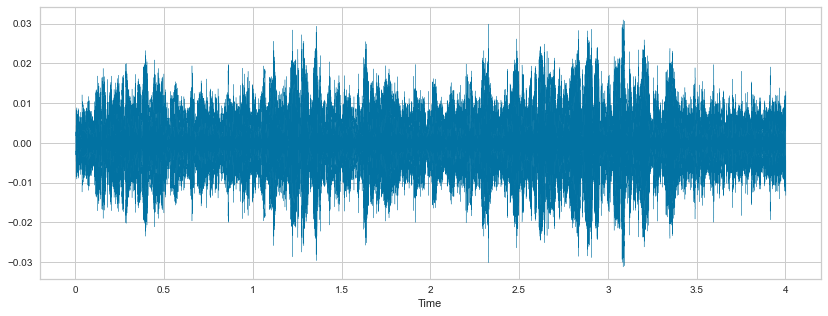

In [146]:
#sampling a file from a row
sample_row = randrange(len(df))
sample_filename = df['relative_path'][sample_row]
sample_label = taxonomy.get(df['classID'][sample_row])
print('Sample label is:', sample_label)
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(sample_filename)
#visualise the waveform
librosa.display.waveshow(data,sr=sample_rate) 
#hear the sound
ipd.Audio(sample_filename, rate = sample_rate)

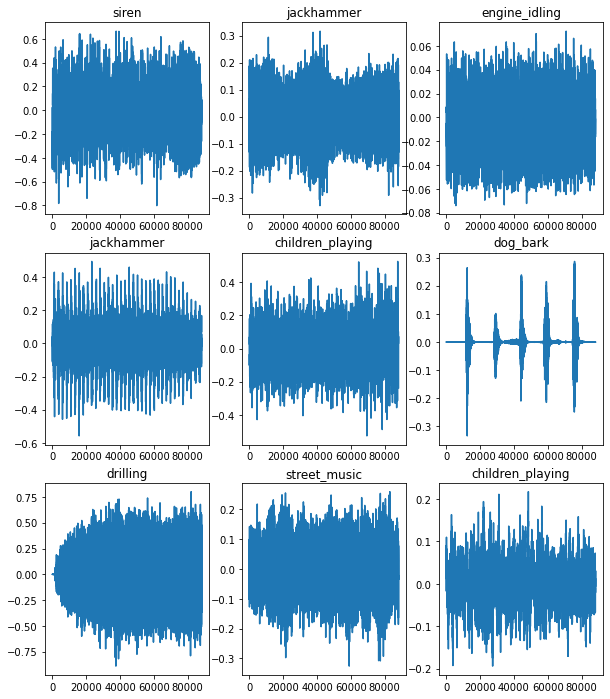

In [11]:
#sampling more waveforms
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

#for i,row in df[0:9].iterrows(): 
for i in range(9):
    row_num = randrange(len(df))
    #wave_sample_rate, audio=wav.read(row['relative_path'])
    data,sample_rate=librosa.load(df['relative_path'][row_num])
    #librosa.display.waveshow(data,sr=sample_rate)
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(data)
    #ax.plot(librosa_audio_data)
    #ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = taxonomy.get(df['classID'][row_num])
    ax.set_title(label)

plt.show()

## Classes

The number of classes are generally evenly distributed for each of the 10 classes, except for the gun shot and car horn class. The gun shot class is generally not applicable in Singapore, leaving only the car horn class which has about half the number of samples compared to the others, which is relatively acceptable.

In [19]:
df_full['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

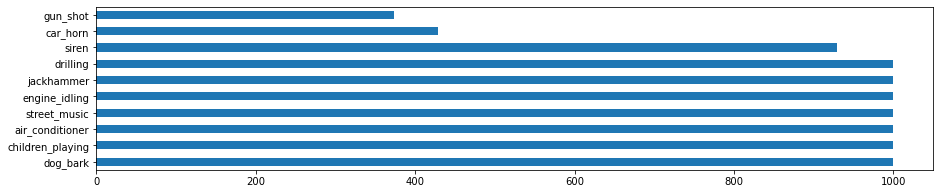

In [20]:
df_full['class'].value_counts().plot(kind='barh', figsize=(15,3));

## Other metadata

We will not be using the rest of the metadata for our modeling, but we will examine them briefly nonetheless. 

#### Start and end times which the clips were extracted from

The start and end times refer to the timings from which the UrbanSound8K audio clip was extracted from its original source. 

In [15]:
df_full['start'].describe()

count    8732.000000
mean       38.645409
std        74.292126
min         0.000000
25%         3.000000
50%        10.376492
75%        35.131372
max       600.125356
Name: start, dtype: float64

In [16]:
df_full['end'].describe()

count    8732.000000
mean       42.253312
std        74.369669
min         0.105962
25%         6.839398
50%        14.000000
75%        38.866979
max       604.125356
Name: end, dtype: float64

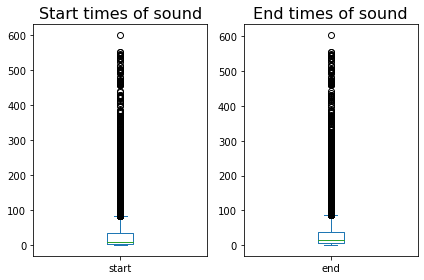

In [17]:
#A1. Initialize figure and subplots :
#initiate figure and plots with subplot grid variables
n_rows = 1
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols)# #sharey=True)

#A2. Indicate position of each subplot before plot codes:
plt.subplot(1,2,1) 
df_full['start'].plot(kind ='box').set_title(
    'Start times of sound',fontsize=16)

#A2. Indicate position of each subplot before plot codes:
plt.subplot(1,2,2) 
df_full['end'].plot(kind ='box').set_title(
    'End times of sound',fontsize=16)

#A3. Close off the figure
plt.tight_layout()
plt.show();

#### Folds

In [21]:
df_full['fold'].value_counts()

4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

#### Salience (foreground vs background)

There are more foreground than background class. For this study, we assume there is no difference in quality between foreground and background sources of the audio clips. 

In [22]:
df_full['salience'].value_counts()

1    5702
2    3030
Name: salience, dtype: int64

<AxesSubplot:>

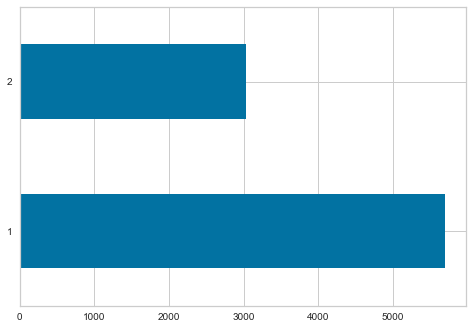

In [149]:
df_full['salience'].value_counts().plot(kind = 'barh')

#### Length of clips

Most of the clips are 4 seconds long. Some are shorter, with the shortest at 0.05 seconds.

In [26]:
def length_extractor(file):
    #audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    length = librosa.get_duration(filename = file)
    return round(length, 3)

In [28]:
df_full['clip_length'] = df_full['relative_path'].apply(lambda x: length_extractor(x))

df_full.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,relative_path,clip_length
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav,0.318
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav,4.000
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav,4.000
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav,4.000
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav,4.000


In [29]:
df_full['clip_length'].describe()

count    8732.000000
mean        3.607522
std         0.974394
min         0.050000
25%         4.000000
50%         4.000000
75%         4.000000
max         4.037000
Name: clip_length, dtype: float64

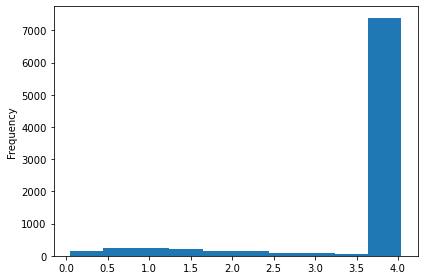

In [30]:
df_full['clip_length'].plot(kind = 'hist')
plt.tight_layout()

## Feature extraction

We will extract the features of each sound clip by generating the Mel-frequency cepstral coefficients of the sounds using the Librosa package. The MFCC features will be stored in a dataframe together with the event label for each clip.

In [31]:
def features_extractor(file): #to obtain the mean, transposed mfcc
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast') #extracts audio and sample rate
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128) #extracts the mfcc, same as earlier line #original mfcc = 40
    #delta_mfccs = librosa.feature.delta(mfccs)
    #delta2_mfccs = librosa.feature.delta(mfccs, order = 2)
    #concatenate the mfccs values
    #mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    mfccs_scaled_features = np.mean(mfccs.T,axis=0)
    
    return mfccs_scaled_features

In [32]:
%%time 
extracted_features=[]
label_list = []
for _ ,row in tqdm(df.iterrows()): #iterate through the rows of the dataframe
    filepath = row['relative_path']
    label = row['classID']
    data=features_extractor(filepath) #generate mfcc in a variable called data
    extracted_features.append(data)##store mfcc in list 
    label_list.append(label)

print(len(extracted_features))
print(len(label_list))

3553it [02:12, 26.40it/s]C:\Users\yongl\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8322it [05:04, 36.97it/s]C:\Users\yongl\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
8327it [05:04, 39.89it/s]C:\Users\yongl\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [05:18, 27.41it/s]

8732
8732
Wall time: 5min 18s


In [33]:
### converting extracted_features to Pandas dataframe #works so far
extracted_features_df=pd.DataFrame({'feature': extracted_features,'event_label': label_list})
extracted_features_df.head()

,feature,event_label
0,"[-218.18938, 71.38549, -131.49442, -52.25892, ...",3
1,"[-425.05234, 110.67095, -54.192833, 62.045406,...",2
2,"[-459.82623, 122.82864, -47.908062, 53.302677,...",2
3,"[-414.82184, 102.94826, -36.65685, 54.170742, ...",2
4,"[-447.60776, 115.08627, -53.74607, 61.55309, 1...",2


In [34]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['event_label'].tolist())

In [35]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
#from tensorflow.keras.utils import to_categorical
#from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [36]:
### Train Test Split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [37]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (6985, 128)
Shape of X_test: (1747, 128)
Shape of y_train: (6985, 10)
Shape of y_test: (1747, 10)


In [38]:
X_train[0]

array([-1.32114578e+02,  1.13914940e+02, -2.39274063e+01,  2.83204231e+01,
       -2.00339108e+01,  8.41936207e+00, -2.80250797e+01,  1.20061274e+01,
       -2.44050636e+01,  5.27503014e+00, -1.46134253e+01,  1.62752266e+01,
       -2.10168762e+01,  1.32247400e+00, -2.11327000e+01,  2.50662827e+00,
       -1.33201065e+01,  2.88922286e+00, -5.36910200e+00,  7.10296440e+00,
       -1.00379410e+01, -5.06389713e+00, -1.12010765e+01, -5.34986925e+00,
       -7.59663725e+00, -1.81874275e+00, -6.10214663e+00, -1.62555552e+00,
       -1.58037710e+00,  3.12865019e+00, -8.61282170e-01,  1.96565413e+00,
       -1.84069097e+00,  1.86205804e+00,  2.05297351e+00,  4.83028507e+00,
       -2.75885820e-01,  3.32602429e+00, -1.47902882e+00,  2.89128709e+00,
       -1.99254417e+00, -1.47971446e-02, -5.89981198e-01, -8.18383336e-01,
       -2.24957204e+00,  6.82851601e+00,  6.23391056e+00, -3.00770491e-01,
       -2.60003829e+00, -5.26402235e+00, -3.42158842e+00, -3.10375404e+00,
        1.68405068e+00, -

In [41]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [42]:
### No of classes
num_labels=y.shape[1] #10 unique features

num_labels

10

## Train model

We will train 3 models to help us identify the sound classes in an audio clip, based on the MFCC features and the event labels: 
1. Artificial Neural Network (ANN) - baseline
2. Convolutional Neural Network (CNN)
3. Recurrent Neural Network (RNN)

Our baseline model will be the ANN model. The key metric we will use to evaluate the model performance is accuracy, although we will derive the value of other classification metrics as well.

## Model 1: ANN (baseline)

In [43]:
ann_model = models.Sequential([
    layers.Input(shape=(128,)), #same as number of features in training dataframe #X_train.shape[1]
    ###first layer
    layers.Dense(1000, activation='relu'), 
    layers.Dropout(0.5), #dropout means 50% of 1k nodes not used for next layer 
    ###second layer
    layers.Dense(2000, activation = 'relu' ), 
    layers.Dropout(0.5), 
    ###third layer
    layers.Dense(1000, activation = 'relu'), 
    layers.Dropout(0.5),
    ###fourth layer
    layers.Dense(500, activation = 'relu'), 
    layers.Dropout(0.5), 
    ###fifth layer
    layers.Dense(250, activation = 'relu'), 
    layers.Dropout(0.5), 
    ###sixth layer
    layers.Dense(100, activation = 'relu'), 
    layers.Dropout(0.5), 
    ###final layer
    layers.Dense(num_labels, activation = 'softmax')
     #output values are in the range of 0-1 and may be used as predicted probabilities
    ])

ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              129000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 2000)              2002000   
                                                                 
 dropout_1 (Dropout)         (None, 2000)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_2 (Dropout)         (None, 1000)              0         
                                                                 
 dense_3 (Dense)             (None, 500)               5

In [44]:
ann_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam') 

In [45]:
%%time

num_epochs = 75
num_batch_size = 32 #batching increases speed, but decreases accuracy

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = ann_model.fit(X_train, 
                        y_train, 
                        batch_size=num_batch_size, 
                        epochs=num_epochs, 
                        validation_data=(X_test, y_test), 
                        callbacks=[checkpointer], 
                        verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

#Epoch 75: val_loss did not improve from 0.58589
#219/219 [==============================] - 1s 4ms/step - loss: 0.6819 - accuracy: 0.8004 
#- val_loss: 0.6003 - val_accuracy: 0.8208
#Training completed in time:  0:01:06.594374
#Wall time: 1min 6s

Epoch 1/75
217/219 [============================>.] - ETA: 0s - loss: 5.0230 - accuracy: 0.1143
Epoch 1: val_loss improved from inf to 2.27895, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 2s 6ms/step - loss: 5.0069 - accuracy: 0.1145 - val_loss: 2.2789 - val_accuracy: 0.1986
Epoch 2/75
217/219 [============================>.] - ETA: 0s - loss: 2.3626 - accuracy: 0.1282
Epoch 2: val_loss improved from 2.27895 to 2.26939, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.3623 - accuracy: 0.1281 - val_loss: 2.2694 - val_accuracy: 0.1637
Epoch 3/75
215/219 [============================>.] - ETA: 0s - loss: 2.2913 - accuracy: 0.1519
Epoch 3: val_loss improved from 2.26939 to 2.24101, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.2917 - accuracy: 0.1526 - val_loss: 2.2410 - val_accuracy: 0.1992
Ep

Epoch 26/75
215/219 [============================>.] - ETA: 0s - loss: 1.0121 - accuracy: 0.6750
Epoch 26: val_loss improved from 0.88919 to 0.86419, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 5ms/step - loss: 1.0114 - accuracy: 0.6746 - val_loss: 0.8642 - val_accuracy: 0.7178
Epoch 27/75
205/219 [===========================>..] - ETA: 0s - loss: 1.0200 - accuracy: 0.6753
Epoch 27: val_loss improved from 0.86419 to 0.83907, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 1.0166 - accuracy: 0.6752 - val_loss: 0.8391 - val_accuracy: 0.7350
Epoch 28/75
211/219 [===========================>..] - ETA: 0s - loss: 0.9838 - accuracy: 0.6822
Epoch 28: val_loss improved from 0.83907 to 0.82540, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 0.9838 - accuracy: 0.6820 - val_loss: 0.8254 - val_accuracy:

Epoch 53/75
209/219 [===========================>..] - ETA: 0s - loss: 0.7189 - accuracy: 0.7833
Epoch 53: val_loss did not improve from 0.61533
219/219 [==============================] - 1s 4ms/step - loss: 0.7147 - accuracy: 0.7848 - val_loss: 0.6745 - val_accuracy: 0.8002
Epoch 54/75
210/219 [===========================>..] - ETA: 0s - loss: 0.7322 - accuracy: 0.7826
Epoch 54: val_loss did not improve from 0.61533
219/219 [==============================] - 1s 4ms/step - loss: 0.7321 - accuracy: 0.7828 - val_loss: 0.6504 - val_accuracy: 0.8203
Epoch 55/75
208/219 [===========================>..] - ETA: 0s - loss: 0.7472 - accuracy: 0.7790
Epoch 55: val_loss did not improve from 0.61533
219/219 [==============================] - 1s 4ms/step - loss: 0.7441 - accuracy: 0.7792 - val_loss: 0.6721 - val_accuracy: 0.7991
Epoch 56/75
204/219 [==========================>...] - ETA: 0s - loss: 0.6958 - accuracy: 0.7877
Epoch 56: val_loss improved from 0.61533 to 0.58589, saving model to saved_

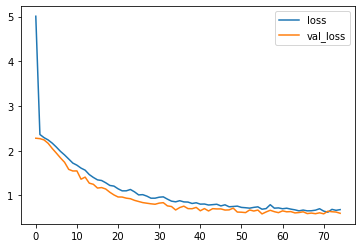

In [46]:
#loss history over the training epochs
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [90]:
ann_test_accuracy=ann_model.evaluate(X_test,y_test,verbose=0)[1]
print(round(ann_test_accuracy, 4))

0.8208


#### Multi-label Confusion matrix

In [49]:
#calculate y_pred
y_pred = ann_model.predict(X_test)

y_pred

55/55 [==============================] - 0s 3ms/step


array([[3.8194467e-14, 1.8657206e-27, 1.8014968e-14, ..., 4.6772682e-28,
        2.5796216e-16, 4.3555667e-15],
       [7.1304768e-08, 1.2097323e-06, 1.4692946e-01, ..., 1.2876773e-15,
        3.4999494e-02, 1.1796731e-04],
       [4.9989607e-10, 3.7314482e-08, 4.0449247e-10, ..., 1.9454667e-06,
        6.6922365e-09, 2.2325365e-07],
       ...,
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0644227e-35, 1.0644755e-20],
       [1.2563139e-01, 2.1786304e-02, 3.1228876e-01, ..., 2.8203335e-02,
        3.2413945e-02, 2.4840833e-01],
       [1.5281680e-01, 1.1535121e-02, 3.6127335e-01, ..., 2.7826704e-02,
        4.2295307e-02, 1.4723749e-01]], dtype=float32)

In [50]:
#works
predicted_label=np.argmax(y_pred,axis=1) #predicted class has highest probability
print('predicted labels:', predicted_label)
predicted_categorical=to_categorical(labelencoder.fit_transform(predicted_label))
print('predicted_categorical:\n', predicted_categorical)#.shape #(1747, 10)

predicted labels: [5 3 4 ... 1 2 2]
predicted_categorical:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [51]:
#works
multilabel_conf_mat = multilabel_confusion_matrix(y_test, predicted_categorical, labels=classes)
multilabel_conf_mat

array([[[1538,   14],
        [  11,  184]],

       [[1653,    3],
        [  18,   73]],

       [[1308,  234],
        [  19,  186]],

       [[1547,   18],
        [  65,  117]],

       [[1543,    2],
        [  30,  172]],

       [[1528,    3],
        [  38,  178]],

       [[1660,    0],
        [  43,   44]],

       [[1546,   14],
        [  13,  174]],

       [[1545,    3],
        [  34,  165]],

       [[1542,   22],
        [  42,  141]]], dtype=int64)

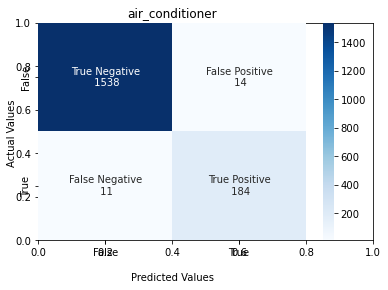

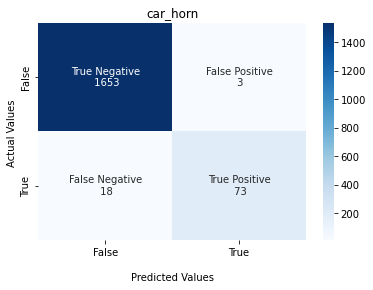

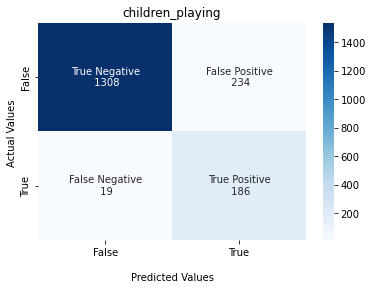

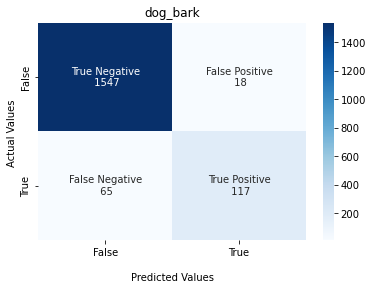

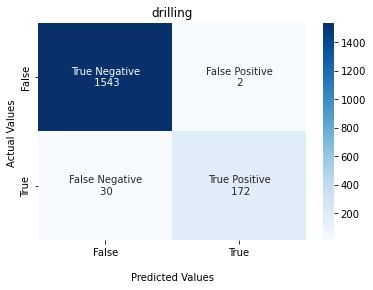

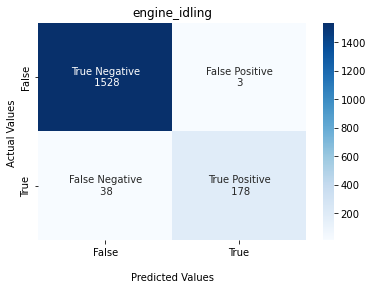

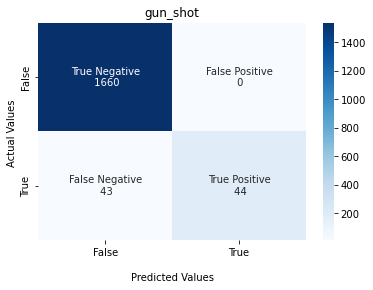

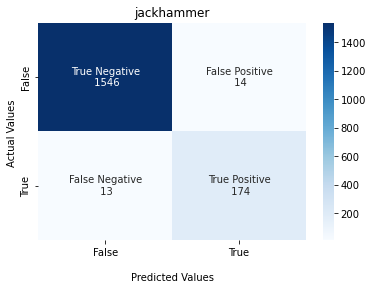

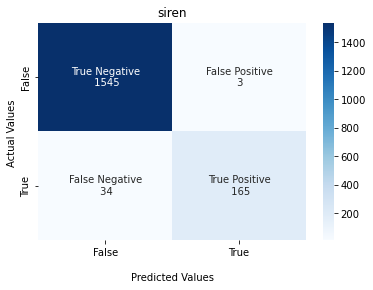

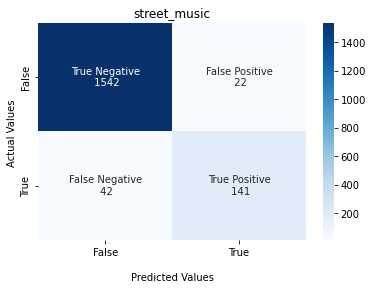

In [52]:
#works
def print_confusion_matrix(ax, i):
    labels = [f'True Negative\n {multilabel_conf_mat[i][0][0]}',f'False Positive\n {multilabel_conf_mat[i][0][1]}',f'False Negative\n {multilabel_conf_mat[i][1][0]}',f'True Positive\n {multilabel_conf_mat[i][1][1]}']
    labels = np.asarray(labels).reshape(2,2)
    ax = fig.add_subplot()
    ax = sns.heatmap(multilabel_conf_mat[0], annot=labels, fmt='', cmap='Blues')
    ax.set_title(f'{names[i]}');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

fig, ax = plt.subplots()
for i in range(10):
    print_confusion_matrix(ax, i)

fig.tight_layout()
plt.show()

In [53]:
test_label=np.argmax(y_test,axis=1)
conf_mat = confusion_matrix(test_label, predicted_label, labels=classes)
conf_mat

array([[184,   0,  10,   0,   0,   0,   0,   0,   0,   1],
       [  0,  73,   8,   2,   1,   0,   0,   2,   0,   5],
       [  5,   1, 186,   4,   1,   0,   0,   1,   0,   7],
       [  2,   0,  57, 117,   0,   1,   0,   0,   3,   2],
       [  1,   0,  18,   0, 172,   0,   0,   9,   0,   2],
       [  0,   0,  36,   0,   0, 178,   0,   0,   0,   2],
       [  0,   1,  30,  11,   0,   0,  44,   0,   0,   1],
       [  1,   0,  10,   0,   0,   0,   0, 174,   0,   2],
       [  1,   0,  32,   1,   0,   0,   0,   0, 165,   0],
       [  4,   1,  33,   0,   0,   2,   0,   2,   0, 141]], dtype=int64)

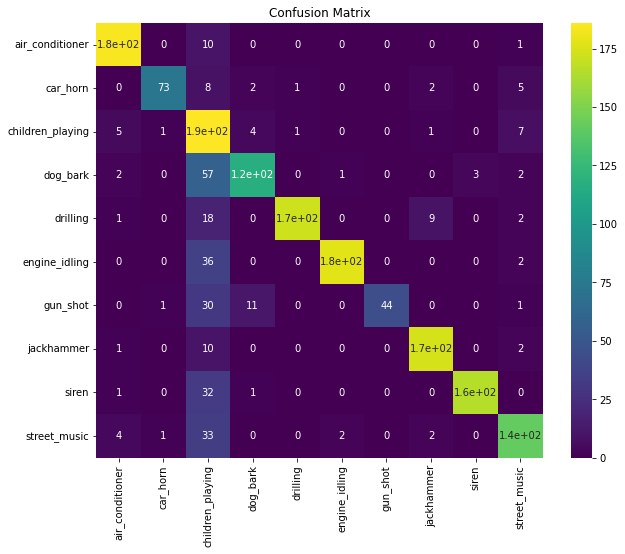

In [54]:
df_cm = pd.DataFrame(conf_mat, index = names, #unique_labels,
                     columns = names) #unique_labels)
plt.figure(figsize = (10,8))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.show()

#### Classification report

In [55]:
print(classification_report(test_label, predicted_label))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       195
           1       0.96      0.80      0.87        91
           2       0.44      0.91      0.60       205
           3       0.87      0.64      0.74       182
           4       0.99      0.85      0.91       202
           5       0.98      0.82      0.90       216
           6       1.00      0.51      0.67        87
           7       0.93      0.93      0.93       187
           8       0.98      0.83      0.90       199
           9       0.87      0.77      0.82       183

    accuracy                           0.82      1747
   macro avg       0.89      0.80      0.83      1747
weighted avg       0.88      0.82      0.83      1747



#### Area under curve of Receiver Operating Characteristic curve (AUC ROC)

In [138]:
y_pred = ann_model.predict(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_pred, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_pred, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_pred, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_pred, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

55/55 [==============================] - 0s 5ms/step
One-vs-One ROC AUC scores:
0.975656 (macro),
0.977769 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.975656 (macro),
0.977769 (weighted by prevalence)


## Model 2 - CNN

In [187]:
inp = Input(shape=(128,1))
#x = layers.Reshape((None, 128, 0, 1))(inp)
x = Conv1D(32, (4) )(inp)#x #,padding="same" #4,10
x = BatchNormalization()(x)
x = Activation("relu")(x)
#x = MaxPooling2D()(x)

x = Conv1D(32*2, (4))(x) #, padding="same" #4,10
x = BatchNormalization()(x)
x = Activation("relu")(x)
#x = MaxPooling2D()(x)

x = Conv1D(32*3, (4))(x)#, padding="same" #4,10
x = BatchNormalization()(x)
x = Activation("relu")(x)
#x = MaxPooling2D()(x)

x = Conv1D(32*3, (4))(x) #, padding="same" #4,10
x = BatchNormalization()(x)
x = Activation("relu")(x)
#x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(64)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
out = Dense(num_labels, activation='softmax')(x)

cnn_model = models.Model(inputs=inp, outputs=out)

cnn_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])


In [57]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 125, 32)           160       
                                                                 
 batch_normalization (BatchN  (None, 125, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 122, 64)           8256      
                                                                 
 batch_normalization_1 (Batc  (None, 122, 64)          256       
 hNormalization)                                             

In [58]:
num_epochs = 20
num_batch_size = 32 #batching increases speed, but decreases accuracy

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = cnn_model.fit(X_train, 
                        y_train, 
                        batch_size=num_batch_size, 
                        epochs=num_epochs, 
                        validation_data=(X_test, y_test), 
                        callbacks=[checkpointer], 
                        verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

#219/219 [==============================] - 2s 7ms/step - loss: 0.0258 - accuracy: 0.9921 
#- val_loss: 0.2556 - val_accuracy: 0.9325
#Training completed in time:  0:00:35.315518

Epoch 1/20
219/219 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.7777
Epoch 1: val_loss improved from inf to 0.65991, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 6s 9ms/step - loss: 0.7533 - accuracy: 0.7777 - val_loss: 0.6599 - val_accuracy: 0.8088
Epoch 2/20
218/219 [============================>.] - ETA: 0s - loss: 0.2994 - accuracy: 0.9136
Epoch 2: val_loss improved from 0.65991 to 0.30811, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 2s 7ms/step - loss: 0.2992 - accuracy: 0.9137 - val_loss: 0.3081 - val_accuracy: 0.9096
Epoch 3/20
212/219 [============================>.] - ETA: 0s - loss: 0.1724 - accuracy: 0.9539
Epoch 3: val_loss improved from 0.30811 to 0.30622, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 2s 7ms/step - loss: 0.1738 - accuracy: 0.9528 - val_loss: 0.3062 - val_accuracy: 0.9073
Ep

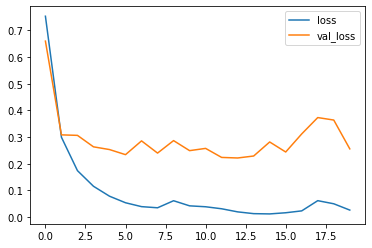

In [61]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [89]:
cnn_test_accuracy=cnn_model.evaluate(X_test,y_test,verbose=0)[1]
print(round(cnn_test_accuracy, 4))

0.9325


#### Multi-label Confusion matrix

In [62]:
y_pred = cnn_model.predict(X_test)

y_pred

55/55 [==============================] - 0s 7ms/step


array([[8.5774936e-06, 3.5300073e-07, 5.3762367e-05, ..., 8.5748197e-04,
        1.1923221e-06, 8.9289688e-06],
       [5.3834947e-07, 9.6074581e-01, 6.0285761e-06, ..., 1.6848606e-06,
        6.1584840e-05, 8.2633849e-03],
       [1.0590303e-06, 4.3950394e-07, 1.5448683e-07, ..., 4.5034257e-03,
        7.8771521e-08, 3.0902406e-06],
       ...,
       [2.4440416e-04, 8.5551685e-01, 1.4370355e-06, ..., 1.2094442e-01,
        5.5209266e-06, 3.3821743e-05],
       [4.0314395e-02, 3.2248970e-03, 4.6296948e-01, ..., 2.4358777e-03,
        2.6450771e-01, 4.6749517e-02],
       [1.0910081e-03, 3.9938250e-06, 6.9915277e-01, ..., 2.8737995e-07,
        3.0828299e-04, 5.5138243e-04]], dtype=float32)

In [63]:
predicted_label=np.argmax(y_pred,axis=1) #predicted class has highest probability
print('predicted labels:', predicted_label)
predicted_categorical=to_categorical(labelencoder.fit_transform(predicted_label))
print('predicted_categorical:\n', predicted_categorical)#.shape #(1747, 10)

predicted labels: [5 1 4 ... 1 2 2]
predicted_categorical:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [64]:
multilabel_conf_mat = multilabel_confusion_matrix(y_test, predicted_categorical, labels=classes)
multilabel_conf_mat

array([[[1545,    7],
        [   2,  193]],

       [[1654,    2],
        [   8,   83]],

       [[1522,   20],
        [  27,  178]],

       [[1542,   23],
        [  20,  162]],

       [[1528,   17],
        [  10,  192]],

       [[1521,   10],
        [   7,  209]],

       [[1660,    0],
        [  10,   77]],

       [[1552,    8],
        [   6,  181]],

       [[1541,    7],
        [  10,  189]],

       [[1540,   24],
        [  18,  165]]], dtype=int64)

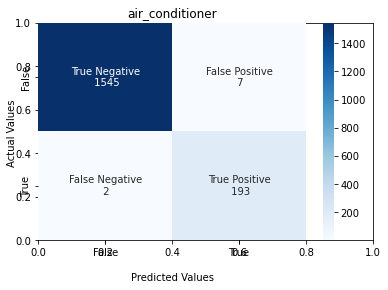

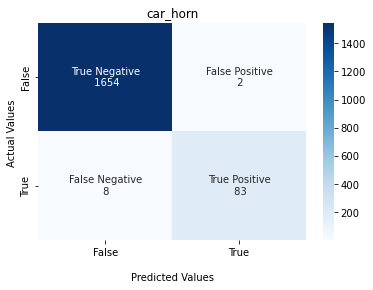

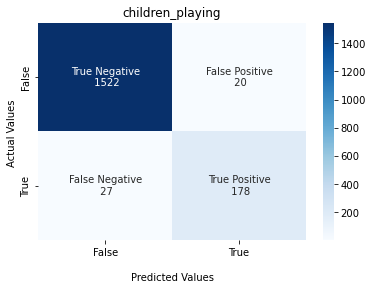

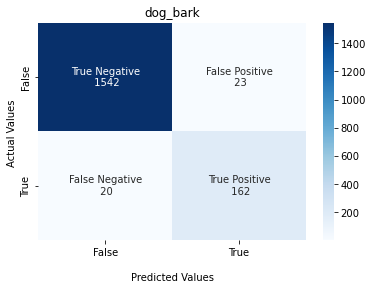

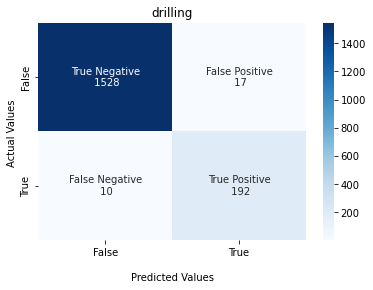

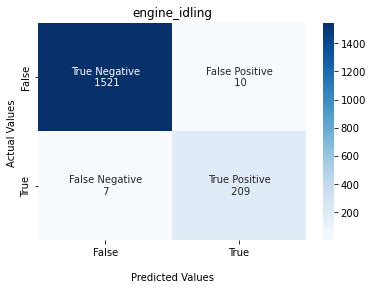

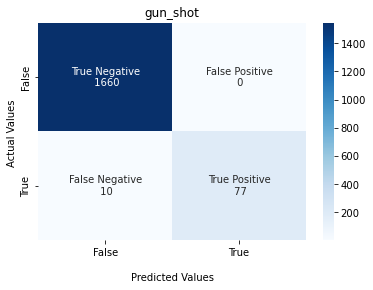

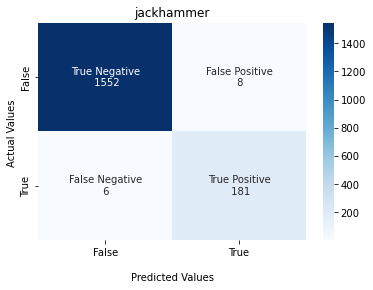

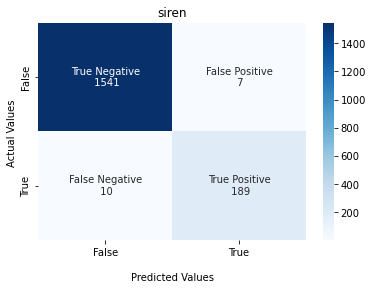

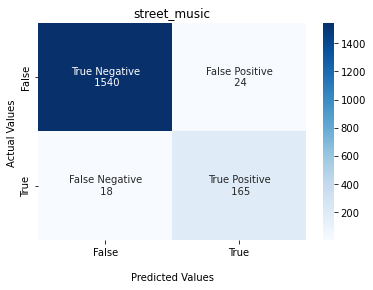

In [65]:
def print_confusion_matrix(ax, i):
    labels = [f'True Negative\n {multilabel_conf_mat[i][0][0]}',f'False Positive\n {multilabel_conf_mat[i][0][1]}',f'False Negative\n {multilabel_conf_mat[i][1][0]}',f'True Positive\n {multilabel_conf_mat[i][1][1]}']
    labels = np.asarray(labels).reshape(2,2)
    ax = fig.add_subplot()
    ax = sns.heatmap(multilabel_conf_mat[0], annot=labels, fmt='', cmap='Blues')
    ax.set_title(f'{names[i]}');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

fig, ax = plt.subplots()
for i in range(10):
    print_confusion_matrix(ax, i)

fig.tight_layout()
plt.show()

In [66]:
test_label=np.argmax(y_test,axis=1)
conf_mat = confusion_matrix(test_label, predicted_label, labels=classes)
conf_mat

array([[193,   0,   0,   1,   0,   1,   0,   0,   0,   0],
       [  1,  83,   0,   2,   1,   0,   0,   0,   1,   3],
       [  2,   1, 178,   9,   2,   2,   0,   0,   1,  10],
       [  0,   0,   9, 162,   3,   3,   0,   0,   2,   3],
       [  0,   0,   0,   1, 192,   0,   0,   6,   0,   3],
       [  1,   1,   1,   1,   2, 209,   0,   0,   1,   0],
       [  0,   0,   2,   4,   3,   0,  77,   1,   0,   0],
       [  0,   0,   0,   0,   3,   0,   0, 181,   0,   3],
       [  2,   0,   2,   3,   1,   0,   0,   0, 189,   2],
       [  1,   0,   6,   2,   2,   4,   0,   1,   2, 165]], dtype=int64)

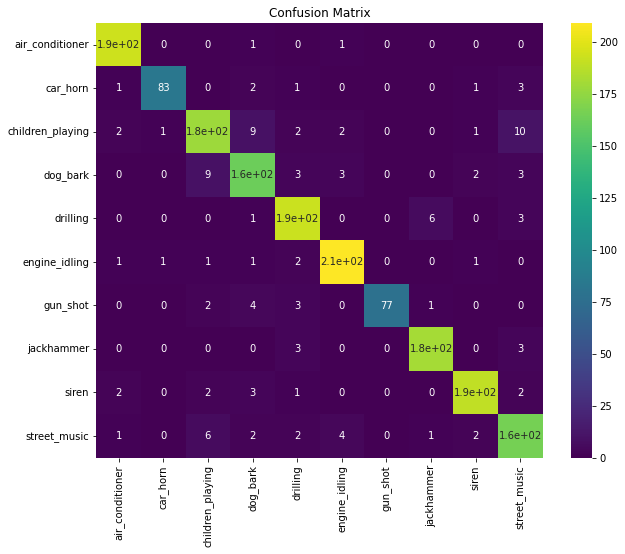

In [67]:
df_cm = pd.DataFrame(conf_mat, index = names, #unique_labels,
                     columns = names) #unique_labels)
plt.figure(figsize = (10,8))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.show()

#### Classification report

In [68]:
print(classification_report(test_label, predicted_label))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       195
           1       0.98      0.91      0.94        91
           2       0.90      0.87      0.88       205
           3       0.88      0.89      0.88       182
           4       0.92      0.95      0.93       202
           5       0.95      0.97      0.96       216
           6       1.00      0.89      0.94        87
           7       0.96      0.97      0.96       187
           8       0.96      0.95      0.96       199
           9       0.87      0.90      0.89       183

    accuracy                           0.93      1747
   macro avg       0.94      0.93      0.93      1747
weighted avg       0.93      0.93      0.93      1747



#### AUC ROC

In [139]:
y_pred = cnn_model.predict(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_pred, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_pred, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_pred, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_pred, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

55/55 [==============================] - 0s 5ms/step
One-vs-One ROC AUC scores:
0.995712 (macro),
0.995771 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.995712 (macro),
0.995771 (weighted by prevalence)


## Model 3 - RNN

In [69]:
inp = Input(shape=(128,1))

# First conv block
x = layers.Conv1D(64, (3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(inp)

# RNNs
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)#(inp)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
x = layers.Flatten()(x)

# Output layer
x = layers.BatchNormalization(momentum = 0.8)(x)
x = layers.Dense(512 , activation="relu")(x)
x = layers.Dense(256 , activation="relu")(x)  

o = layers.Dense(num_labels , activation="softmax", name="last_dense")(x) 
rnn_model = keras.models.Model(inputs=inp, outputs=o, name="model")

rnn_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

In [70]:
rnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 Conv1 (Conv1D)              (None, 128, 64)           256       
                                                                 
 bidirectional (Bidirectiona  (None, 128, 256)         197632    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 256)         394240    
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 batch_normalization_5 (Batc  (None, 32768)            131072

In [71]:
num_epochs = 10
num_batch_size = 32 #batching increases speed, but decreases accuracy

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = rnn_model.fit(X_train, 
                        y_train, 
                        batch_size=num_batch_size, 
                        epochs=num_epochs, 
                        validation_data=(X_test, y_test), 
                        callbacks=[checkpointer], 
                        verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

#Epoch 10: val_loss improved from 0.42524 to 0.40624, saving model to saved_models\audio_classification.hdf5
#219/219 [==============================] - 10s 47ms/step - loss: 0.1350 - accuracy: 0.9641 
#- val_loss: 0.4062 - val_accuracy: 0.9027
#Training completed in time:  0:01:45.666845

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 1.6034 - accuracy: 0.6364
Epoch 1: val_loss improved from inf to 0.61113, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 15s 50ms/step - loss: 1.6034 - accuracy: 0.6364 - val_loss: 0.6111 - val_accuracy: 0.8031
Epoch 2/10
218/219 [============================>.] - ETA: 0s - loss: 0.4853 - accuracy: 0.8459
Epoch 2: val_loss improved from 0.61113 to 0.59027, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 10s 46ms/step - loss: 0.4847 - accuracy: 0.8461 - val_loss: 0.5903 - val_accuracy: 0.8397
Epoch 3/10
218/219 [============================>.] - ETA: 0s - loss: 0.3173 - accuracy: 0.8985
Epoch 3: val_loss improved from 0.59027 to 0.43092, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 10s 47ms/step - loss: 0.3169 - accuracy: 0.8986 - val_loss: 0.4309 - val_accuracy: 0.8

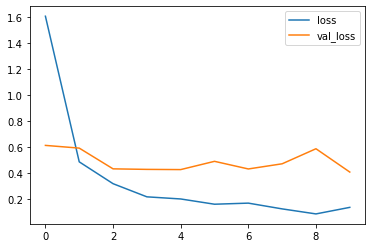

In [73]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [88]:
rnn_test_accuracy=rnn_model.evaluate(X_test,y_test,verbose=0)[1]
print(round(rnn_test_accuracy, 4))

0.9027


#### Multi-label Confusion matrix

In [74]:
y_pred = rnn_model.predict(X_test)

y_pred

55/55 [==============================] - 2s 25ms/step


array([[1.99824060e-10, 2.33046447e-11, 6.12931150e-10, ...,
        2.20389582e-10, 9.62502744e-10, 3.56842195e-11],
       [1.18806015e-11, 9.00582850e-01, 2.01478407e-08, ...,
        1.98827870e-08, 6.96128118e-05, 9.92179960e-02],
       [1.16949150e-06, 3.01575845e-18, 3.80213351e-06, ...,
        9.92296170e-03, 1.25944683e-15, 1.44219736e-09],
       ...,
       [1.93835881e-09, 9.82674897e-01, 8.71399025e-05, ...,
        3.78997722e-10, 4.19407664e-09, 1.29779772e-04],
       [3.40016530e-04, 1.52063338e-04, 9.87766027e-01, ...,
        1.58184810e-06, 9.82680451e-03, 1.28087559e-04],
       [3.22209351e-04, 7.05929342e-05, 9.84001637e-01, ...,
        7.00874692e-09, 1.91769097e-04, 1.05212061e-02]], dtype=float32)

In [75]:
predicted_label=np.argmax(y_pred,axis=1) #predicted class has highest probability
print('predicted labels:', predicted_label)
predicted_categorical=to_categorical(labelencoder.fit_transform(predicted_label))
print('predicted_categorical:\n', predicted_categorical)#.shape #(1747, 10)

predicted labels: [5 1 4 ... 1 2 2]
predicted_categorical:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [76]:
multilabel_conf_mat = multilabel_confusion_matrix(y_test, predicted_categorical, labels=classes)
multilabel_conf_mat

array([[[1543,    9],
        [   8,  187]],

       [[1653,    3],
        [  17,   74]],

       [[1486,   56],
        [  17,  188]],

       [[1546,   19],
        [  38,  144]],

       [[1524,   21],
        [  15,  187]],

       [[1520,   11],
        [   5,  211]],

       [[1660,    0],
        [  18,   69]],

       [[1552,    8],
        [  22,  165]],

       [[1538,   10],
        [  14,  185]],

       [[1531,   33],
        [  16,  167]]], dtype=int64)

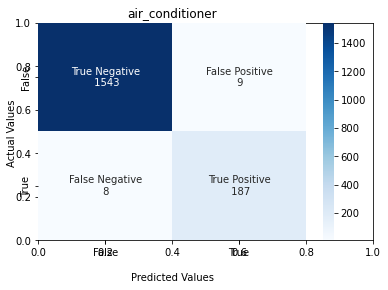

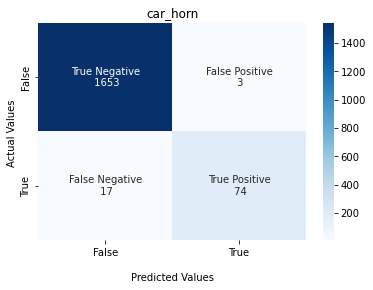

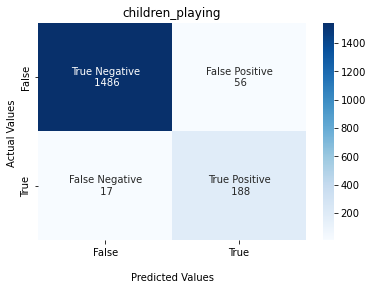

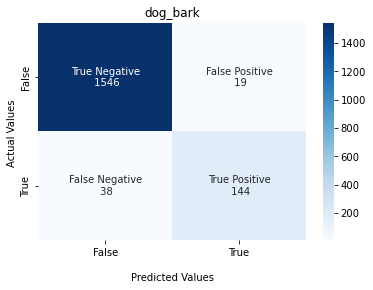

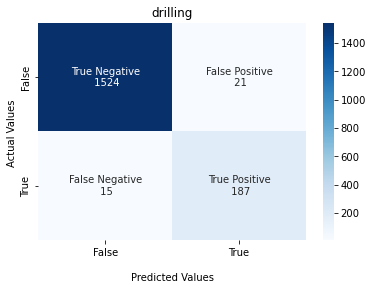

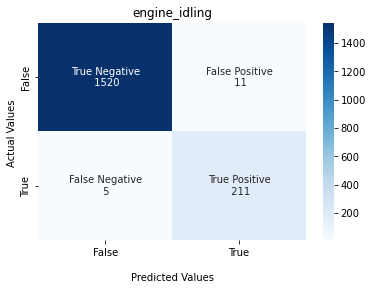

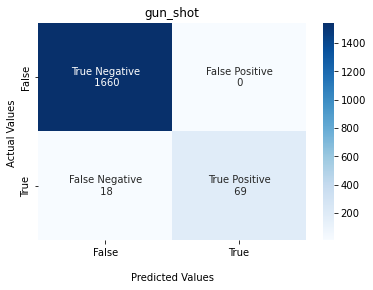

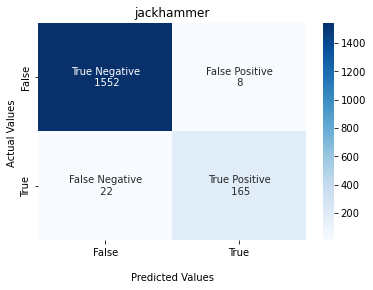

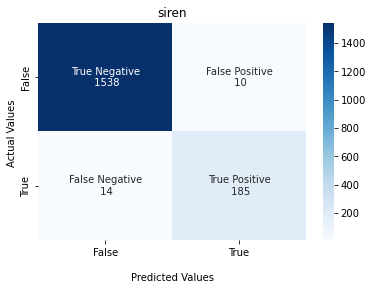

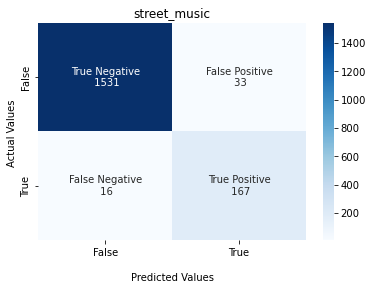

In [77]:
def print_confusion_matrix(ax, i):
    labels = [f'True Negative\n {multilabel_conf_mat[i][0][0]}',f'False Positive\n {multilabel_conf_mat[i][0][1]}',f'False Negative\n {multilabel_conf_mat[i][1][0]}',f'True Positive\n {multilabel_conf_mat[i][1][1]}']
    labels = np.asarray(labels).reshape(2,2)
    ax = fig.add_subplot()
    ax = sns.heatmap(multilabel_conf_mat[0], annot=labels, fmt='', cmap='Blues')
    ax.set_title(f'{names[i]}');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

fig, ax = plt.subplots()
for i in range(10):
    print_confusion_matrix(ax, i)

fig.tight_layout()
plt.show()

In [78]:
test_label=np.argmax(y_test,axis=1)
conf_mat = confusion_matrix(test_label, predicted_label, labels=classes)
conf_mat

array([[187,   0,   5,   0,   0,   0,   0,   0,   0,   3],
       [  1,  74,   1,   0,   3,   1,   0,   0,   2,   9],
       [  0,   0, 188,   6,   0,   2,   0,   0,   0,   9],
       [  4,   0,  22, 144,   1,   2,   0,   0,   7,   2],
       [  0,   0,   5,   2, 187,   2,   0,   4,   0,   2],
       [  0,   1,   1,   3,   0, 211,   0,   0,   0,   0],
       [  1,   0,   6,   6,   1,   0,  69,   3,   0,   1],
       [  2,   1,   0,   0,  15,   2,   0, 165,   0,   2],
       [  1,   0,   6,   1,   0,   1,   0,   0, 185,   5],
       [  0,   1,  10,   1,   1,   1,   0,   1,   1, 167]], dtype=int64)

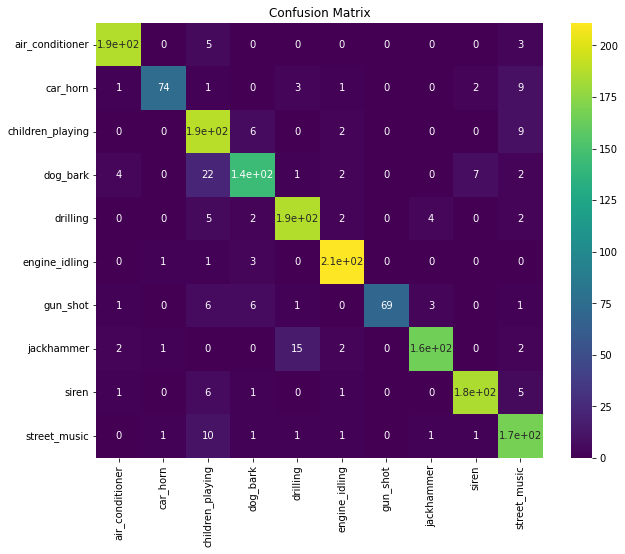

In [79]:
df_cm = pd.DataFrame(conf_mat, index = names, #unique_labels,
                     columns = names) #unique_labels)
plt.figure(figsize = (10,8))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.show()

#### Classification report

In [80]:
print(classification_report(test_label, predicted_label))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       195
           1       0.96      0.81      0.88        91
           2       0.77      0.92      0.84       205
           3       0.88      0.79      0.83       182
           4       0.90      0.93      0.91       202
           5       0.95      0.98      0.96       216
           6       1.00      0.79      0.88        87
           7       0.95      0.88      0.92       187
           8       0.95      0.93      0.94       199
           9       0.83      0.91      0.87       183

    accuracy                           0.90      1747
   macro avg       0.92      0.89      0.90      1747
weighted avg       0.91      0.90      0.90      1747



#### AUC ROC

In [140]:
y_pred = rnn_model.predict(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_pred, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_pred, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_pred, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_pred, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

55/55 [==============================] - 1s 26ms/step
One-vs-One ROC AUC scores:
0.993895 (macro),
0.994202 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.993895 (macro),
0.994202 (weighted by prevalence)


In [97]:
model_accuracies = [round(ann_test_accuracy, 4), round(cnn_test_accuracy, 4), round(rnn_test_accuracy, 4)]
models = ['ANN (baseline)', 'CNN', 'RNN']    
accuracy_df = pd.DataFrame(model_accuracies, index = models, columns = ['Test accuracy'])
accuracy_df

,Test accuracy
ANN (baseline),0.8208
CNN,0.9325
RNN,0.9027


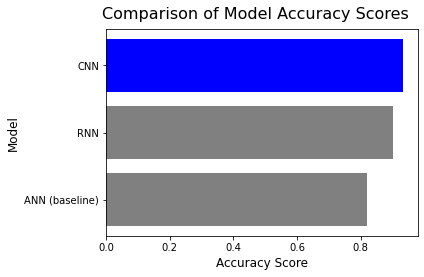

In [126]:
#visualising accuracy scores based on test score
sorted_df = accuracy_df.sort_values('Test accuracy',ascending=True)
plt.barh(sorted_df.index, sorted_df['Test accuracy'],color=['grey', 'grey', 'blue'])
plt.suptitle('Comparison of Model Accuracy Scores', fontsize=16,x = 0.6, y=0.95) #0.93
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.tight_layout()

The CNN model has the highest test accuracy of 93.25% amongst the three models, well above our baseline model's 82.08%. The RNN model has a slightly lower accuracy at 90.27%. The One-vs-One and One-vs-Rest ROC AUC scores, which evaluate the model's ability to differentiate between the classes, are very high for all 3 models, ranging between 97 - 99%. Looking at other classfication metrics, for the CNN model, the precision, recall and f1 are the best amongst the 3 models, around 93% for all metrics. That being said, the performance of all the models in these metrics are relatively close as well, hovering around 90%.  

We will choose model 2, our CNN model, as the best performing model, as it has the highest accuracy.

## Trying models on external audio clips

Here we will test both the CNN against sound clips that are not from the UrbanSound8K dataset. We will use one of a dog bark and the other a siren, as per the sound clip titles. The model was able to predict the sound clip classes correctly.

### Using CNN model

In [160]:
def show_wave(filename):
    plt.figure(figsize=(14,5))
    data,sample_rate=librosa.load(sample_filename)
    #visualise the waveform
    librosa.display.waveshow(data,sr=sample_rate) 

In [175]:
def predict_sample(filename, model):
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128) #40 each mfcc, 120 since concat 3 mfccs
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    print(mfccs_scaled_features.shape)
    if str(model) == 'cnn':
        predict_x=cnn_model.predict(mfccs_scaled_features) #probabilities
        print('cnn model selected')
    elif str(model) == 'rnn':
        predict_x=rnn_model.predict(mfccs_scaled_features) #probabilities
        print('rnn model selected')
    predicted_label=np.argmax(predict_x,axis=1) #predicted class has highest probability
    print('predicted label:', predicted_label)
    prediction_class = taxonomy.get(int(predicted_label))
    print('sound label:', filename)
    print('predicted sound class:', prediction_class)

#### Siren

Sample sound: sample_siren.wav


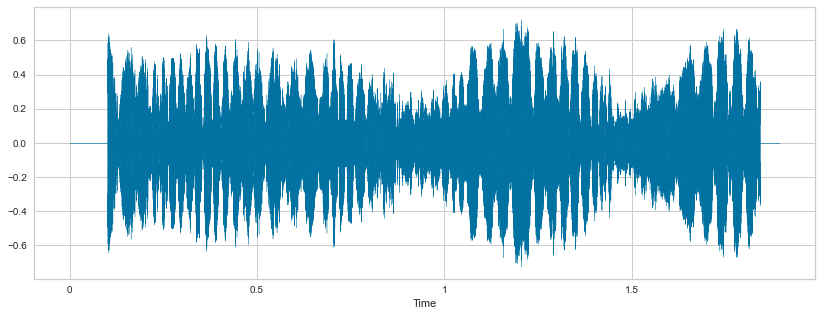

In [162]:
sample_filename = 'sample_siren.wav'
print('Sample sound:', sample_filename)
show_wave(sample_filename)
ipd.Audio(sample_filename, rate = sample_rate)

In [176]:
predict_sample('sample_siren.wav', 'cnn')

(1, 128)
1/1 [==============================] - 0s 15ms/step
cnn model selected
predicted label: [8]
sound label: sample_siren.wav
predicted sound class: siren


#### Dog bark

Sample sound: sample_dog_bark.wav


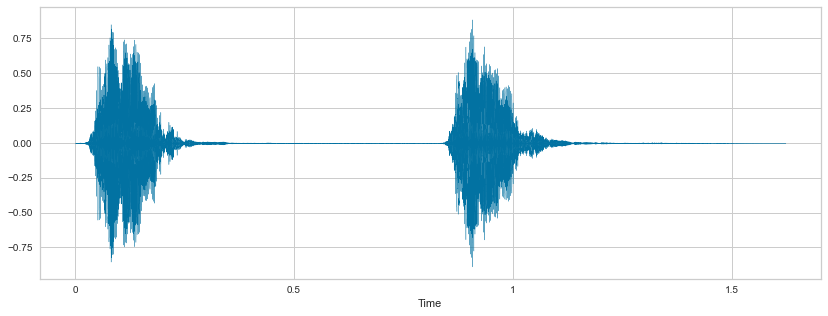

In [163]:
sample_filename = 'sample_dog_bark.wav'
print('Sample sound:', sample_filename)
show_wave(sample_filename)
ipd.Audio(sample_filename, rate = sample_rate)

In [178]:
predict_sample('sample_dog_bark.wav', 'cnn')

(1, 128)
1/1 [==============================] - 0s 21ms/step
cnn model selected
predicted label: [3]
sound label: sample_dog_bark.wav
predicted sound class: dog_bark


## Conclusion

The key findings can be summarised as follow:

1. Chosen model for sound class identification is the **Convolutional Neural Network**. The model had the highest accuracy score of 93.25% based on the test score. The model also exhbited high AUC ROC and good classification metric values, well above our baseline accuracy of 82.02%, which was based on an ANN model.
2. Good performance from RNN model as well - The RNN model has a slightly lower accuracy score of 90.27%, but comparable classification metrics to the CNN model.
3. The CNN model was able to predict correctly the sound class of two audio clips outside the UrbanSound8K dataset. 

## Limitations and future direction

1. ***Restricted audio file properties that can be tested*** - The lack of more extensive audio processing techniques in the preprocessing functions, as well as limtations in sound formats that can be read by the librosa package, means that only small wav files can be read and predicted with the model in this notebook. Future work should include more comprehensive file reading and processing methods.
2. ***Limited sound classes in the UrbanSound8K dataset*** - There are only 10 sound classes in the training dataset labels, which is quite small to describe the various sounds in the urban setting. E.g. weather sounds are missing. A more extensive database can be used to train the model in the future.
3. ***Dataset is not localised to Singapore context*** - The UrbanSound8K dataset is sourced from an open audio repository, hence the sounds might not be applicable to local context. 
4. ***Need to improve ability to deal with overlapping sounds and noises*** - The audio clips in the UrbanSound8K dataset are relatively clear, which helps the models to easily identify the labels using MFCC features. However, in real-life, noise recordings tend to have many overlapping sources and background sounds, which is likely to significantly reduce the effectiveness of the MFCC method. More robust cleaning and preprocessing approaches such as using the mel-spectrogram should be explored.